# Analysis of SARS-Cov-2 intrasample variation

You can access your data via the dataset number. For example, ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/galaxy-ipython).

In [1]:
# Set display to the full length

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 668kB/s eta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1


In [3]:
!pip install --upgrade seaborn

     |████████████████████████████████| 216 kB 4.0 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [4]:
# install pandasql
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=28405 sha256=603bc7f75e2c6218f289bdd1f8a07cb2afb4f6cc6a89332bdb30a88cccde26a9
  Stored in directory: /home/jovyan/.cache/pip/wheels/33/dc/52/fcd9f8b4528e668922f2b776e423db0a07bdd973ea02ffd2ef
Successfully built pandasql


In [5]:
import pandas as pd
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
%matplotlib inline

This notebook imports two datasets from Galaxy history:

 - a table of variants detected by mapping SRR10903401, SRR10903402, and SRR10971381 to 2019-nCoV reference NC_045512 (variable `var`)
 - a GenBank file for NC_045512

In [6]:
# Import two datasets
# The number inside `get()` function corresponds to history ID

var_file = 122     # Number of history item with variant list
gb_file = 22       # Number of histoiry item containing genbank annoration for NC_045512

var_path = get(var_file)
gb_path = get(gb_file)

In [10]:
# Clean artifacts of SNPeff from file headers

!cat {var_path} | sed s/EFF\\\[\\\*\\\]\.//g > var.tab

In [11]:
# Create dataframes

var  = pd.read_csv('var.tab', sep='\t')

In [12]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON
0,SRR11140744,NC_045512,253,A,G,2468,0.006483,5,"1625,825,13,3",.,.,.,.,.
1,SRR11140744,NC_045512,270,A,G,3039,0.003291,0,"1977,1044,7,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gAg/gGg
2,SRR11140744,NC_045512,298,A,G,3549,0.003663,0,"2211,1323,8,5",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,aaA/aaG
3,SRR11140744,NC_045512,312,T,C,3800,0.004211,0,"2318,1464,9,7",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cTc/cCc
4,SRR11140744,NC_045512,330,A,G,4157,0.005292,0,"2478,1653,13,9",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cAg/cGg


In [13]:
# Add fiels describing viant type and set it to "I" (indels) for those rows that reference or alternative are gaps (-)
# or are of unequial length

var.loc[ ( var['REF'] == '-' ) | ( var['ALT'] == '-' ) ,'type'] = 'I'
var.loc[ ( var['ALT'].str.len() != var['REF'].str.len() ), 'type' ] = 'I'

In [14]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR11140744,NC_045512,253,A,G,2468,0.006483,5,"1625,825,13,3",.,.,.,.,.,NaN
1,SRR11140744,NC_045512,270,A,G,3039,0.003291,0,"1977,1044,7,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gAg/gGg,NaN
2,SRR11140744,NC_045512,298,A,G,3549,0.003663,0,"2211,1323,8,5",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,aaA/aaG,NaN
3,SRR11140744,NC_045512,312,T,C,3800,0.004211,0,"2318,1464,9,7",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cTc/cCc,NaN
4,SRR11140744,NC_045512,330,A,G,4157,0.005292,0,"2478,1653,13,9",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cAg/cGg,NaN


In [15]:
# Set type field for SNPs
var.loc[ ( var['REF'].str.len() == 1 ) & ( var['ALT'].str.len() == 1 ) & (var['type'].isnull()), 'type'] = 'S'

In [16]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR11140744,NC_045512,253,A,G,2468,0.006483,5,"1625,825,13,3",.,.,.,.,.,S
1,SRR11140744,NC_045512,270,A,G,3039,0.003291,0,"1977,1044,7,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gAg/gGg,S
2,SRR11140744,NC_045512,298,A,G,3549,0.003663,0,"2211,1323,8,5",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,aaA/aaG,S
3,SRR11140744,NC_045512,312,T,C,3800,0.004211,0,"2318,1464,9,7",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cTc/cCc,S
4,SRR11140744,NC_045512,330,A,G,4157,0.005292,0,"2478,1653,13,9",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cAg/cGg,S


In [17]:
# Set type field for MNPs 
var.loc[ ( ( var['REF'].str.len() > 1 ) & ( var['ALT'].str.len() == var['REF'].str.len() ) ) , 'type'  ] = 'M'

In [18]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR11140744,NC_045512,253,A,G,2468,0.006483,5,"1625,825,13,3",.,.,.,.,.,S
1,SRR11140744,NC_045512,270,A,G,3039,0.003291,0,"1977,1044,7,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gAg/gGg,S
2,SRR11140744,NC_045512,298,A,G,3549,0.003663,0,"2211,1323,8,5",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,aaA/aaG,S
3,SRR11140744,NC_045512,312,T,C,3800,0.004211,0,"2318,1464,9,7",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cTc/cCc,S
4,SRR11140744,NC_045512,330,A,G,4157,0.005292,0,"2478,1653,13,9",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cAg/cGg,S


In [19]:
# Select counts by Sample and by type

pysqldf('select Sample, type, count(*) from var group by Sample, type')

,Sample,type,count(*)
0,SRR11140744,S,3956
1,SRR11140746,S,2767
2,SRR11140748,S,3276
3,SRR11140750,S,126


In [24]:
# Select counts by Sample and by type for SNPs wil allele frequency above 5%

pysqldf('select Sample, type, count(*) from var where AF > 0.02 group by Sample, type')

,Sample,type,count(*)
0,SRR11140744,S,9
1,SRR11140746,S,6
2,SRR11140748,S,9
3,SRR11140750,S,41


In [40]:
print(pysqldf('select Sample, EFFECT, count(*) as N from var where EFFECT != "SPLICE_SITE_REGION+SYNONYMOUS_STOP" group by Sample, EFFECT').pivot(index='Sample',columns='EFFECT',values='N').fillna(0))

EFFECT          .  NON_SYNONYMOUS_CODING  START_LOST  STOP_GAINED  \
Sample                                                              
SRR11140744  29.0                 2304.0         3.0         25.0   
SRR11140746  22.0                 1604.0         1.0         20.0   
SRR11140748  36.0                 1899.0         2.0         24.0   
SRR11140750   4.0                   76.0         0.0          1.0   

EFFECT       SYNONYMOUS_CODING  
Sample                          
SRR11140744             1594.0  
SRR11140746             1120.0  
SRR11140748             1315.0  
SRR11140750               45.0  


In [38]:
print(pysqldf('select Sample, EFFECT, count(*) as N from var where AF >= 0.02 group by Sample, EFFECT').pivot(index='Sample',columns='EFFECT',values='N').fillna(0))

EFFECT         .  NON_SYNONYMOUS_CODING  STOP_GAINED  SYNONYMOUS_CODING
Sample                                                                 
SRR11140744  0.0                    4.0          0.0                5.0
SRR11140746  1.0                    2.0          0.0                3.0
SRR11140748  0.0                    6.0          0.0                3.0
SRR11140750  1.0                   24.0          1.0               16.0


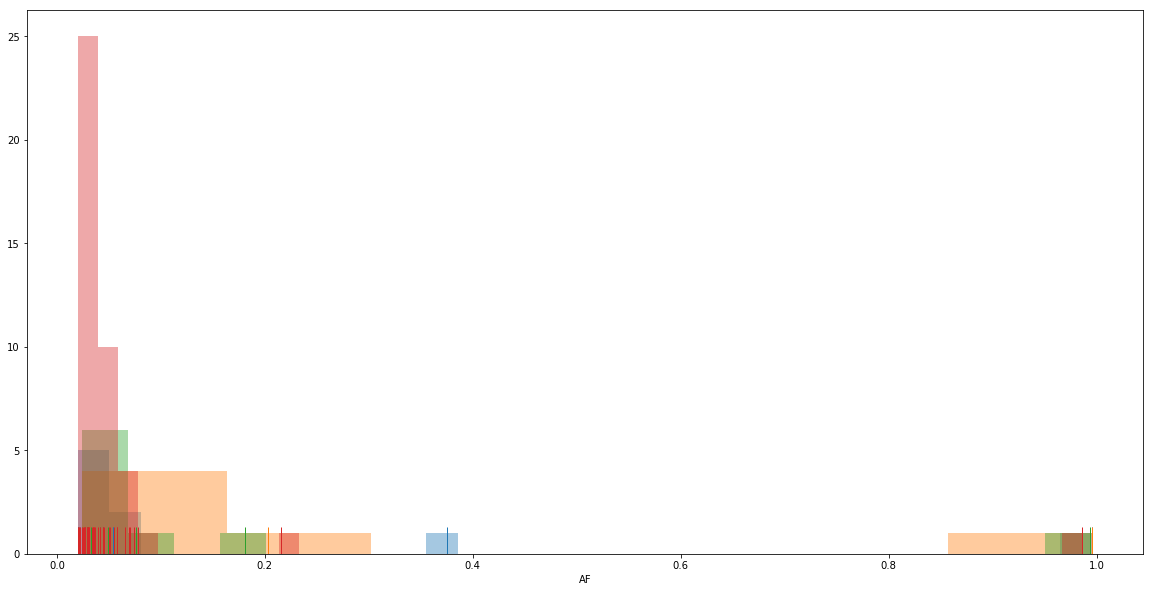

In [28]:
# Plot histogram of allele frequencies for three sample
# Restricted to variants with minor allele frequency above 5%

plt.figure(figsize=(20,10))
for sample in var['Sample'].unique():
    sns.distplot(var['AF'][(var['AF']>=0.02) & (var['Sample']==sample)],kde=False,rug=True)

In [29]:
# Define categorical columns

for col in ['IMPACT','FUNCLASS','EFFECT']:
    var[col] = var[col].astype('category')

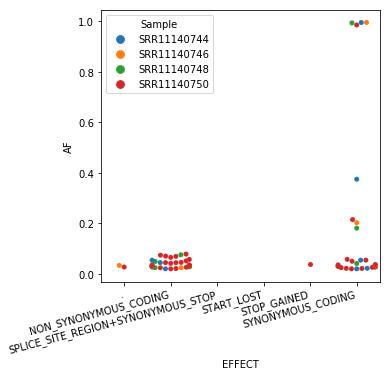

In [30]:
# Plot Allele frequences by samples and functional categories

plt.figure(figsize=(5,5))
g = sns.swarmplot(x='EFFECT',y='AF',data=var[var['AF']>=0.02], hue='Sample')
g.set_xticklabels(g.get_xticklabels(), rotation=15, horizontalalignment='right')

In [31]:
# Read GenBank file with annotations for NC_045512
from Bio import SeqIO
record = SeqIO.read(gb_path,'genbank')

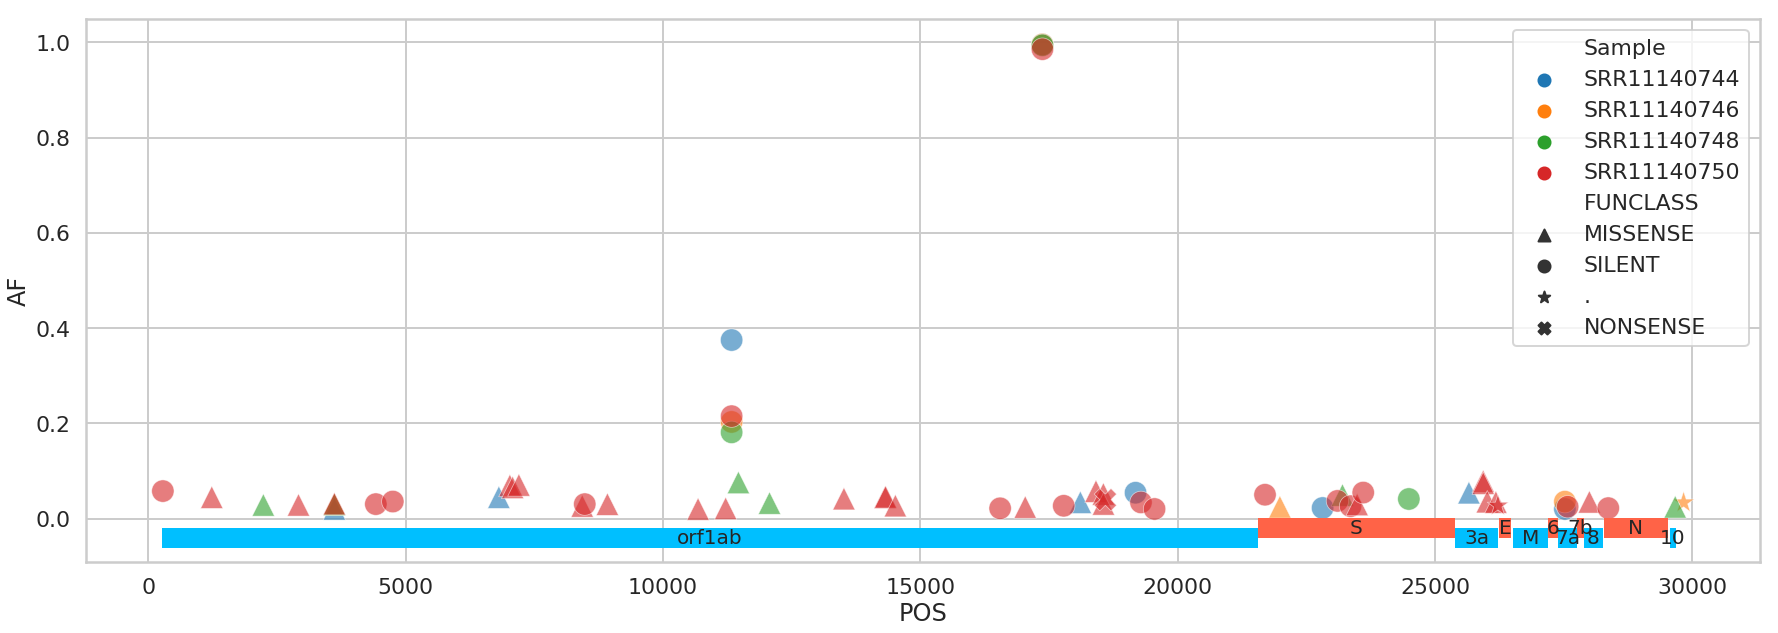

In [35]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set_context("poster")
sns.set_style("whitegrid")
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o"}
sns.scatterplot(x='POS',y='AF',data=var[var['AF']>=0.02],hue='Sample',style='FUNCLASS',legend='brief',alpha=0.6,s=500,markers=markers)
i = 0
for feature in record.features:
    if feature.type == 'gene':
        i += 1
        gene_name = feature.qualifiers['gene'][0]
        if gene_name.startswith('ORF'):
            gene_name=gene_name[3:]
        if i % 2 == 0:
            color ='tomato'
            y = -.02
        else:
            color ='deepskyblue'
            y = -0.04
        plt.hlines(y,feature.location._start.position, feature.location._end.position, linewidth=20,color=color)
        plt.text(feature.location._start.position+(feature.location._end.position-feature.location._start.position)//2, y, gene_name,horizontalalignment='center',verticalalignment='center',fontsize=20)

In [42]:
# List varinats by Sample and by position highlighting allel frequencies

var[var['AF']>0.02].style.bar(subset=['AF'],color='#d65f5f')

In [50]:
var[var['AF']>0.02].to_csv('wisc.tab', sep="\t", index=False)

In [51]:
put('wisc.tab')